# Covid-19 v České republice

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
import urllib.request
import json
import datetime as dt

plt.style.use('ggplot')

def autolabel(rects, ax, val_prec=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height!=height:height=0
        if val_prec == 0:
            height_str = f'{height:.0f}'
        elif val_prec == 1:
            height_str = f'{height:.1f}'            
        else:
            height_str = f'{height:.2f}'
        ax.annotate(height_str,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

with urllib.request.urlopen("https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.json") as url:
    data = json.loads(url.read().decode())

    

In [167]:
df = pd.DataFrame(data['data'])
df['datum'] = pd.to_datetime(df['datum'], errors='coerce')
df['datum'] = df['datum'].dt.date

In [168]:
df.tail()

,datum,kumulovany_pocet_nakazenych,kumulovany_pocet_vylecenych,kumulovany_pocet_umrti,kumulovany_pocet_provedenych_testu
87,2020-04-23,7187,2599,209,203632
88,2020-04-24,7273,2741,215,210761
89,2020-04-25,7352,2812,219,215207
90,2020-04-26,7404,2831,222,218588
91,2020-04-27,7445,2834,223,226255


In [169]:
df.columns = ['date', 'positive_total', 'recovered_total', 'deceased_total', 'tested_total']
df['positive_daily'] = df['positive_total'] - df['positive_total'].shift(1)
df['recovered_daily'] = df['recovered_total'] - df['recovered_total'].shift(1)
df['deceased_daily'] = df['deceased_total'] - df['deceased_total'].shift(1)
df['tested_daily'] = df['tested_total'] - df['tested_total'].shift(1)

df['active'] = df['positive_total'] - df['recovered_total'] - df['deceased_total'] 


df['positive_increase']=0
#df = totalPositiveTests
df['positive_increase'] = (df['positive_total'] - \
                  df['positive_total'].shift(1)) / \
                  df['positive_total'].shift(1)
df['positive_increase_5d'] = (df['positive_increase'] + \
                              df['positive_increase'].shift(1) + \
                              df['positive_increase'].shift(2) + \
                              df['positive_increase'].shift(3) + \
                              df['positive_increase'].shift(4)) / 5

df['growth_factor'] = df['positive_daily'] / df['positive_daily'].shift(1)
df['ones'] = 1


In [170]:
df.tail()

,date,positive_total,recovered_total,deceased_total,tested_total,positive_daily,recovered_daily,deceased_daily,tested_daily,active,positive_increase,positive_increase_5d,growth_factor,ones
87,2020-04-23,7187,2599,209,203632,55.0,138.0,3.0,7899.0,4379,0.007712,0.015544,0.555556,1
88,2020-04-24,7273,2741,215,210761,86.0,142.0,6.0,7129.0,4317,0.011966,0.015172,1.563636,1
89,2020-04-25,7352,2812,219,215207,79.0,71.0,4.0,4446.0,4321,0.010862,0.012778,0.918605,1
90,2020-04-26,7404,2831,222,218588,52.0,19.0,3.0,3381.0,4351,0.007073,0.010338,0.658228,1
91,2020-04-27,7445,2834,223,226255,41.0,3.0,1.0,7667.0,4388,0.005538,0.008630,0.788462,1


## Vývoj počtu pozitivně testovaných

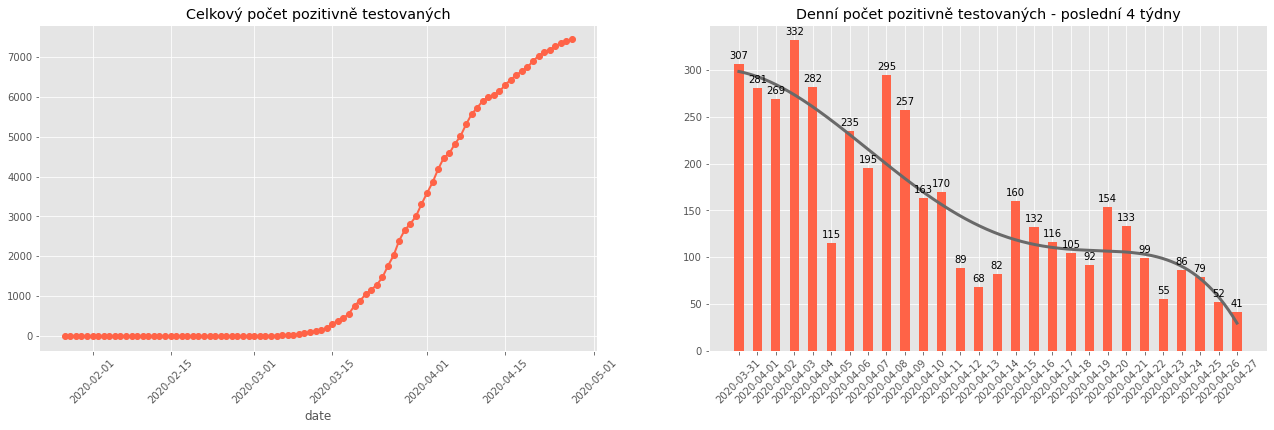

In [171]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date', 
                        y='positive_total', 
                        kind='line', 
                        style='tomato',
                        marker='o',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, 0]) #.index) #daily['date']
y = np.array(df.iloc[-days_back:, 5]) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet pozitivně testovaných - poslední 4 týdny')

plt.show()

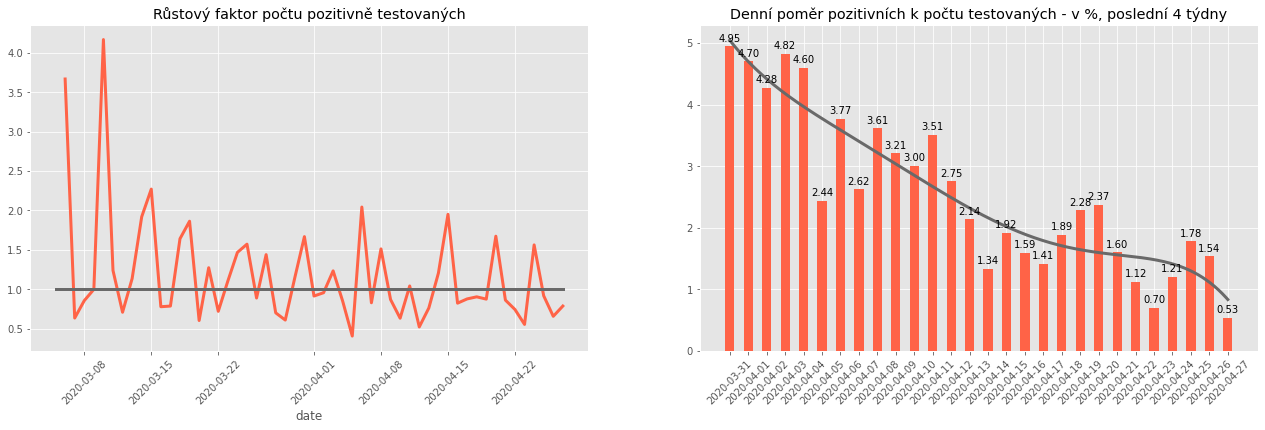

In [172]:
# interpoolace křivkou

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df[38:].plot(x='date', 
                    y=['growth_factor','ones'], 
                    kind='line',
                    style=['tomato', 'dimgray'],
                    linewidth=3,
                    #marker=['o',],
                    grid=True, 
                    legend=False,
                    ax=ax1,                        
                    title='Růstový faktor počtu pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, 0]) #.index) #daily['date']
y = np.array(100*(df.iloc[-days_back:, 5]  / df.iloc[-days_back:, 8])) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

#rects1 = ax2.bar(x, y, color='red')

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2, val_prec=2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní poměr pozitivních k počtu testovaných - v %, poslední 4 týdny')
plt.show()

## Vývoj počtu testovaných

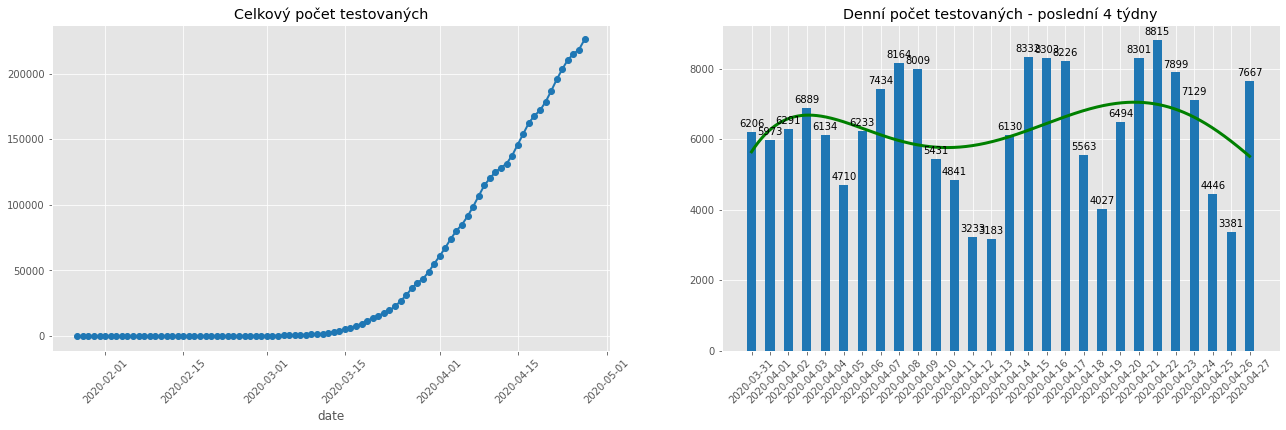

In [174]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date', 
                        y='tested_total', 
                        kind='line', 
                        style='tab:blue',
                        marker='o',
                        #color='royalblue',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, 0]) #.index) #daily['date']
y = np.array(df.iloc[-days_back:, 8]) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tab:blue')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'g-', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet testovaných - poslední 4 týdny')

plt.show()

## Vývoj průměrného denního nárůstu pozitivně testovaných 

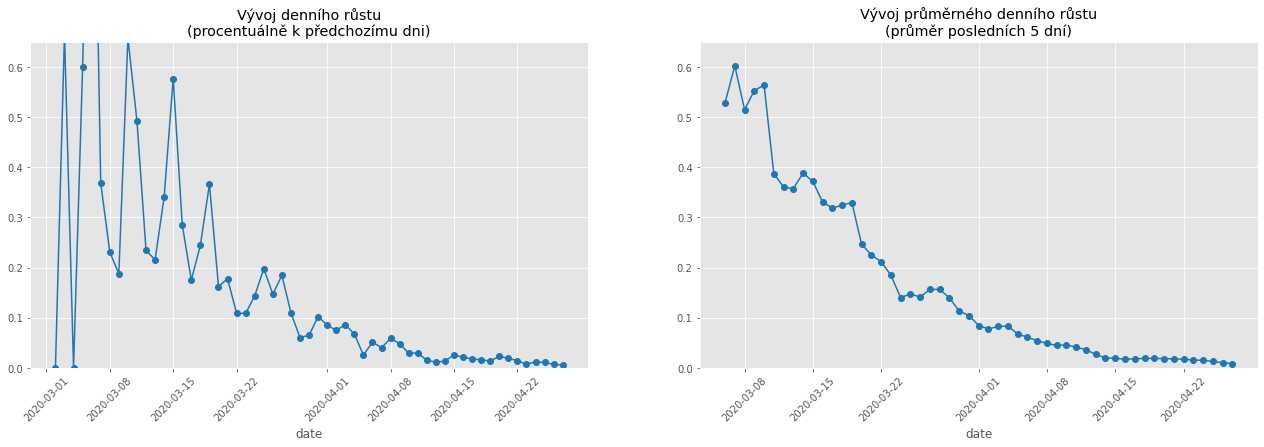

In [175]:

#totalPositiveTests.tail()

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date',
             y='positive_increase', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax1,
             title='Vývoj denního růstu\n(procentuálně k předchozímu dni)')
ax1.tick_params(axis="x", rotation=45) 

df.plot(x='date',
             y='positive_increase_5d', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax2,
             title='Vývoj průměrného denního růstu\n(průměr posledních 5 dní)')
ax2.tick_params(axis="x", rotation=45) 


plt.show()


# Počty uzdravených a zemřelých

Poslední den 2020-04-27 (neúplná data): 3.0 uzdravených, 1.0 zemřelých


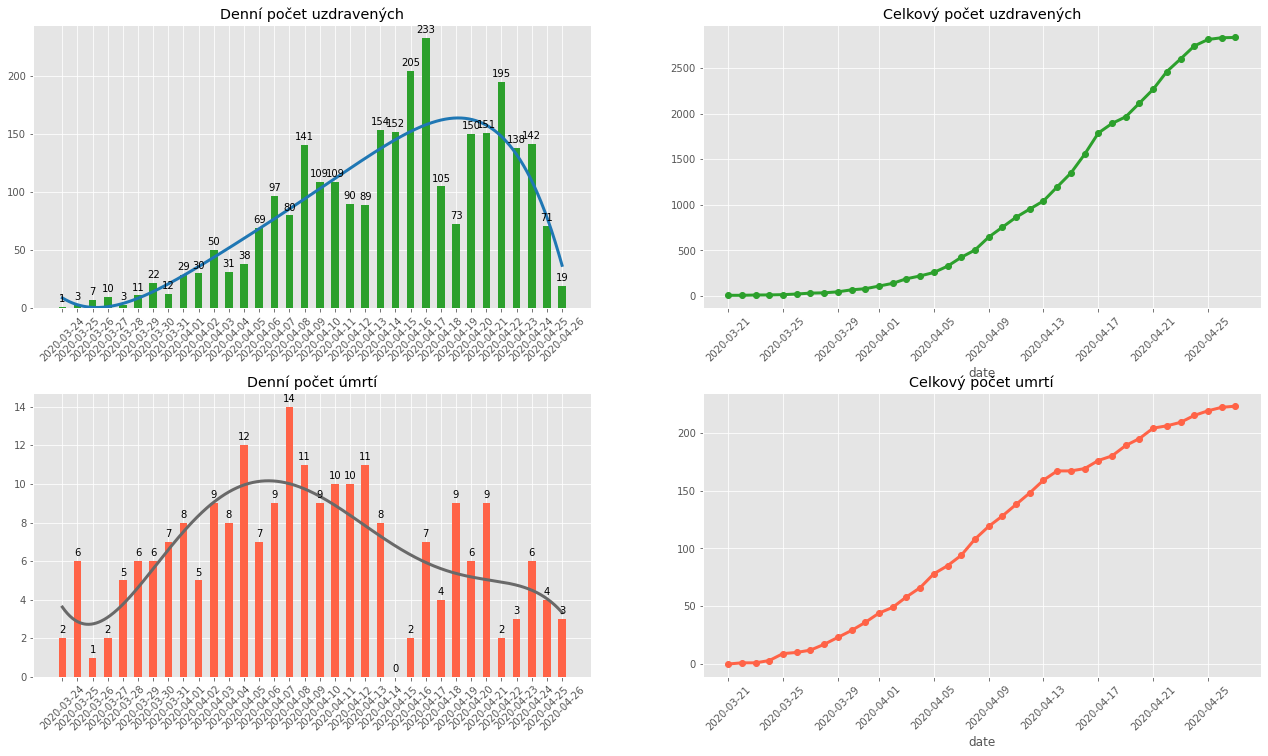

In [176]:
days_back=35

print(f'Poslední den {df.iloc[-1, 0]} (neúplná data): {df.iloc[-1,6]} uzdravených, {df.iloc[-1,7]} zemřelých')
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = np.arange(days_back-1)
x_labels = np.array(df.iloc[-days_back:-1,0])
y = np.array(df.iloc[-days_back:-1, 6]) ## 'recovered' -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title('Denní počet uzdravených')
plt.subplots_adjust(hspace=0.3)

df[df['date']>dt.date(2020, 3, 20)].plot(x='date', 
            y='recovered_total', 
            kind='line',
            linewidth=3,
            style='tab:green',
            marker='o',
            grid=True, 
            legend=False,
            ax=ax2,
            title='Celkový počet uzdravených')
ax2.tick_params(axis="x", rotation=45)

x = np.arange(days_back-1)
x_labels = np.array(df.iloc[-days_back:-1, 0])
y = np.array(df.iloc[-days_back:-1, 7]) ## deceased bez posledního dne (neúplná data)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax3.bar(x, y, width=.5, color='tomato')
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax3)

ax3.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax3.set_title('Denní počet úmrtí')
#plt.subplots_adjust(hspace=0.3)

df[df['date']>dt.date(2020, 3, 20)].plot(x='date', 
            y='deceased_total', 
            kind='line',
            linewidth=3,
            style='tomato',
            marker='o',
            grid=True,
            legend=False,
            ax=ax4,
            title='Celkový počet umrtí')
ax4.tick_params(axis="x", rotation=45)

plt.show()

# Celkový počet pozitivně testovaných vs. aktivní případy

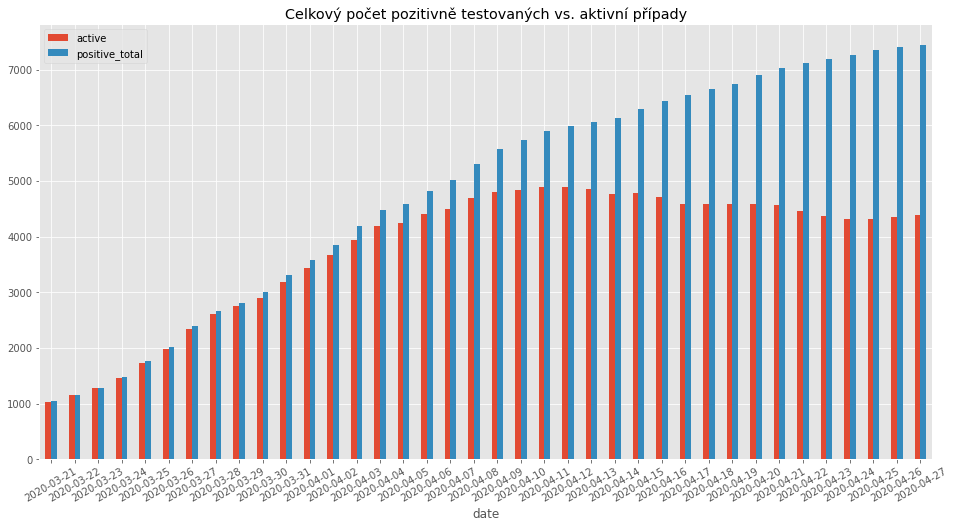

In [177]:
df[df['date']>dt.date(2020, 3, 20)].plot(x='date', 
            y=['active', 'positive_total'], 
            kind='bar', 
            #style='r+-',
            figsize=(16, 8),
            grid=True, 
            title='Celkový počet pozitivně testovaných vs. aktivní případy')
plt.xticks(rotation=30)
plt.show()